# Problem: Predicting Airplane Delays

The goals of this notebook are:
- Process and create a dataset from downloaded ZIP files
- Exploratory data analysis (EDA)
- Establish a baseline model and improve it

## Introduction to business scenario
You work for a travel booking website that is working to improve the customer experience for flights that were delayed. The company wants to create a feature to let customers know if the flight will be delayed due to weather when the customers are booking the flight to or from the busiest airports for domestic travel in the US. 

You are tasked with solving part of this problem by leveraging machine learning to identify whether the flight will be delayed due to weather. You have been given access to the a dataset of on-time performance of domestic flights operated by large air carriers. You can use this data to train a machine learning model to predict if the flight is going to be delayed for the busiest airports.

### Dataset
The provided dataset contains scheduled and actual departure and arrival times reported by certified US air carriers that account for at least 1 percent of domestic scheduled passenger revenues. The data was collected by the Office of Airline Information, Bureau of Transportation Statistics (BTS). The dataset contains date, time, origin, destination, airline, distance, and delay status of flights for flights between 2014 and 2018.
The data are in 60 compressed files, where each file contains a CSV for the flight details in a month for the five years (from 2014 - 2018). The data can be downloaded from this link: [https://ucstaff-my.sharepoint.com/:f:/g/personal/ibrahim_radwan_canberra_edu_au/Er0nVreXmihEmtMz5qC5kVIB81-ugSusExPYdcyQTglfLg?e=bNO312]. Please download the data files and place them on a relative path. Dataset(s) used in this assignment were compiled by the Office of Airline Information, Bureau of Transportation Statistics (BTS), Airline On-Time Performance Data, available with the following link: [https://www.transtats.bts.gov/Fields.asp?gnoyr_VQ=FGJ]. 

# Step 1: Prepare the environment 

Use one of the labs which we have practised on with the Amazon Sagemakers where you perform the following steps:
1. Start a lab.
2. Create a notebook instance and name it "oncloudproject".
3. Increase the used memory to 25 GB from the additional configurations.
4. Open Jupyter Lab and upload this notebook into it.
5. Upload the two combined CVS files (combined_csv_v1.csv and combined_csv_v2.csv), which you created in Part A of this project.

# Step 2: Build and evaluate simple models

Write code to perform the follwoing steps:
1. Split data into training, validation and testing sets (70% - 15% - 15%).
2. Use linear learner estimator to build a classifcation model.
3. Host the model on another instance
4. Perform batch transform to evaluate the model on testing data
5. Report the performance metrics that you see better test the model performance 

Note: You are required to perform the above steps on the two combined datasets separatey and to comments on the difference.

#  Combined_csv_v1.csv

In [1]:
# download the files

################# Please create a data folder and place the Combined_csv_v1.csv and Combined_csv_v2.csv files
##############     inside the folder



# Import necessary libraries
import warnings
import pandas as pd
from sklearn.model_selection import train_test_split
import boto3
import sagemaker
from sagemaker.inputs import TrainingInput
from sagemaker.image_uris import retrieve
import os
import io
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


Matplotlib is building the font cache; this may take a moment.


In [2]:

# Suppress warnings
warnings.simplefilter('ignore')

# Define your S3 bucket
bucket = 'c94466a2114434l5129986t1w144646741378-labbucket-mqy4dpq71rjd'

# Read in the CSV file
data_path = './data/combined_csv_v1.csv'
df = pd.read_csv(data_path)

# Split data into training, validation, and testing sets (70%, 15%, 15%)
train_df, test_and_validate = train_test_split(df, test_size=0.3, random_state=42, stratify=df['target'])
test_df, validate_df = train_test_split(test_and_validate, test_size=0.5, random_state=42, stratify=test_and_validate['target'])

In [3]:
# Define file names
prefix = 'linear-learner'
train_file = 'train.csv'
test_file = 'test.csv'
validate_file = 'validate.csv'

# Function to upload data to S3
s3_resource = boto3.Session().resource('s3')

def upload_to_s3(filename, folder, dataframe):
    csv_buffer = io.StringIO()
    dataframe.to_csv(csv_buffer, header=False, index=False)
    s3_resource.Bucket(bucket).Object(os.path.join(prefix, folder, filename)).put(Body=csv_buffer.getvalue())

# Upload data to S3
upload_to_s3(train_file, 'train', train_df)
upload_to_s3(test_file, 'test', test_df)
upload_to_s3(validate_file, 'validate', validate_df)

In [5]:
# creating the inputs for the fit() function with the training and validation location
s3_train_data = f"s3://{bucket}/{prefix}/train/{train_file}"
s3_validation_data = f"s3://{bucket}/{prefix}/validate/{validate_file}"
output_location = f"s3://{bucket}/{prefix}/output"
print(f"training files will be taken from: {s3_train_data}")
print(f"validation files will be taken from: {s3_validation_data}")
print(f"training artifacts output location: {output_location}")

# generating the session.s3_input() format for fit() accepted by the sdk
train_data = sagemaker.inputs.TrainingInput(
    s3_train_data,
    distribution="FullyReplicated",
    content_type="text/csv",
    s3_data_type="S3Prefix",
    record_wrapping=None,
    compression=None,
)
validation_data = sagemaker.inputs.TrainingInput(
    s3_validation_data,
    distribution="FullyReplicated",
    content_type="text/csv",
    s3_data_type="S3Prefix",
    record_wrapping=None,
    compression=None,
)

# Get Linear Learner container
container = retrieve('linear-learner', boto3.Session().region_name)

# Define hyperparameters
hyperparams = {
    "feature_dim": str(df.shape[1] - 1),
    "predictor_type": "binary_classifier"
#     ,"mini_batch_size": "200"
}

# Define output path
s3_output_location = f"s3://{bucket}/{prefix}/output/"

# Define Linear Learner model
linear_model = sagemaker.estimator.Estimator(container,
                                             sagemaker.get_execution_role(),
                                             instance_count=1,
                                             instance_type='ml.m4.xlarge',
                                             output_path=s3_output_location,
                                             hyperparameters=hyperparams,
                                             sagemaker_session=sagemaker.Session())

# Fit the model
data_channels = {'train': train_data, 'validation': validation_data}
linear_model.fit(inputs=data_channels, logs=True)

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: 1.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


training files will be taken from: s3://c94466a2114434l5129986t1w144646741378-labbucket-mqy4dpq71rjd/linear-learner/train/train.csv
validation files will be taken from: s3://c94466a2114434l5129986t1w144646741378-labbucket-mqy4dpq71rjd/linear-learner/validate/validate.csv
training artifacts output location: s3://c94466a2114434l5129986t1w144646741378-labbucket-mqy4dpq71rjd/linear-learner/output
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


INFO:sagemaker:Creating training-job with name: linear-learner-2023-11-02-15-44-12-348


2023-11-02 15:44:12 Starting - Starting the training job...
2023-11-02 15:44:39 Starting - Preparing the instances for training.........
2023-11-02 15:45:44 Downloading - Downloading input data...
2023-11-02 15:46:24 Training - Downloading the training image......
2023-11-02 15:47:30 Training - Training image download completed. Training in progress...Docker entrypoint called with argument(s): train
Running default environment configuration script
[11/02/2023 15:47:46 INFO 140084472936256] Reading default configuration from /opt/amazon/lib/python3.8/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': 'uniform', 'init_scale': '0.07', 'init_sigma': '0.01', 'init_bias': '0.0', 'optimizer': 'auto', 'loss

In [7]:
# Batch transform
batch_X = test_df.iloc[:, 1:]
batch_X_file = 'batch-in.csv'
upload_to_s3(batch_X_file, 'batch-in', batch_X)

batch_output = f"s3://{bucket}/{prefix}/batch-out/"
batch_input = f"s3://{bucket}/{prefix}/batch-in/{batch_X_file}"

linear_transformer = linear_model.transformer(instance_count=1,
                                              instance_type='ml.m4.xlarge',
                                              strategy='MultiRecord',
                                              assemble_with='Line',
                                              output_path=batch_output)

linear_transformer.transform(data=batch_input,
                             data_type='S3Prefix',
                             content_type='text/csv',
                             split_type='Line')
linear_transformer.wait()


INFO:sagemaker:Creating model with name: linear-learner-2023-11-02-16-13-41-877
INFO:sagemaker:Creating transform job with name: linear-learner-2023-11-02-16-13-42-642


................................................Docker entrypoint called with argument(s): serve
Running default environment configuration script
[11/02/2023 16:21:47 INFO 139621577525056] Memory profiler is not enabled by the environment variable ENABLE_PROFILER.
/opt/amazon/lib/python3.8/site-packages/mxnet/model.py:97: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if num_device is 1 and 'dist' not in kvstore:
/opt/amazon/lib/python3.8/site-packages/scipy/optimize/_shgo.py:495: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if cons['type'] is 'ineq':
/opt/amazon/lib/python3.8/site-packages/scipy/optimize/_shgo.py:743: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if len(self.X_min) is not 0:
[11/02/2023 16:21:52 WARNING 139621577525056] Loggers have already been setup.
[11/02/2023 16:21:52 INFO 139621577525056] loaded entry point class algorithm.serve.server_config:config_api
[11/02/2023 16:21:52 INFO 139621577525056] loading entry points
[11/02/20

In [8]:
# Get the results
s3_client = boto3.client('s3')
obj = s3_client.get_object(Bucket=bucket, Key=f"{prefix}/batch-out/{batch_X_file}.out")
target_predicted = pd.read_csv(io.BytesIO(obj['Body'].read()), names=['predicted'])

# Extract the numeric part of the 'predicted' column and convert it to float
target_predicted['predicted'] = target_predicted['predicted'].str.extract(r'score:(\d+\.\d+)').astype(float)

# Convert probabilities to binary
threshold = 0.5
target_predicted_binary = target_predicted['predicted'].apply(lambda x: int(x > threshold))

# Get the true labels
test_labels = test_df.iloc[:, 0]

# Calculate performance metrics
from sklearn.metrics import classification_report
print(classification_report(test_labels, target_predicted_binary))


              precision    recall  f1-score   support

         0.0       0.79      1.00      0.88    193838
         1.0       0.00      0.00      0.00     51500

    accuracy                           0.79    245338
   macro avg       0.40      0.50      0.44    245338
weighted avg       0.62      0.79      0.70    245338



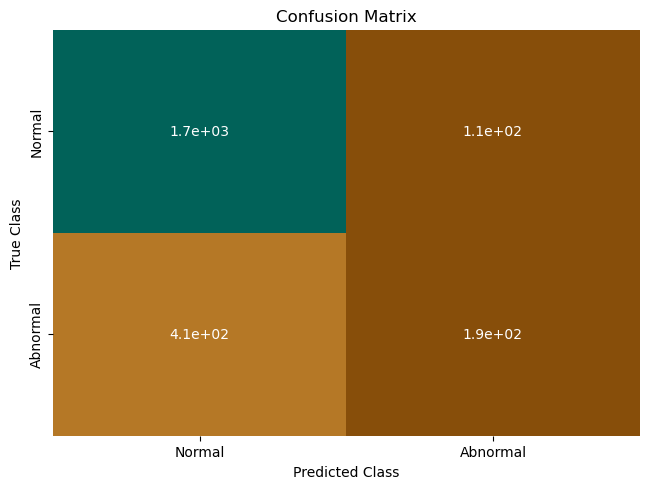

In [11]:
# Confusion Matrix
matrix = confusion_matrix(test_labels, target_predicted_binary)
df_confusion = pd.DataFrame(matrix, index=['Not Delayed','Delayed'],columns=['Not Delayed','Delayed'])

# Visualize Confusion Matrix
colormap = sns.color_palette("BrBG", 10)
sns.heatmap(df_confusion, annot=True, cbar=None, cmap=colormap)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.ylabel("True Class")
plt.xlabel("Predicted Class")
plt.show()

Sensitivity or TPR: 31.43%
Specificity or TNR: 93.99%
Precision: 63.82%
Negative Predictive Value: 80.24%
False Positive Rate: 6.01%
False Negative Rate: 68.57%
False Discovery Rate: 36.18%
Accuracy: 78.20%


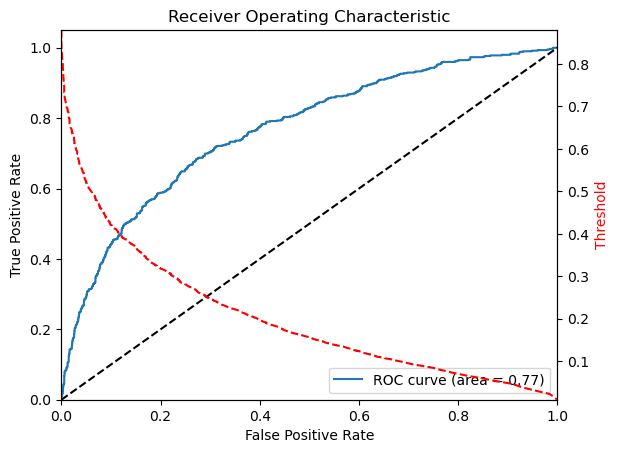

In [14]:

# Calculate confusion matrix
TN, FP, FN, TP = confusion_matrix(test_labels, target_predicted_binary).ravel()

# Calculate metrics
Sensitivity = TP / (TP + FN)
Specificity = TN / (TN + FP)
Precision = TP / (TP + FP)
NPV = TN / (TN + FN)
FPR = FP / (FP + TN)
FNR = FN / (TP + FN)
FDR = FP / (TP + FP)
ACC = (TP + TN) / (TP + FP + FN + TN)

# Print metrics
print(f"Sensitivity or TPR: {Sensitivity * 100:.2f}%")
print(f"Specificity or TNR: {Specificity * 100:.2f}%")
print(f"Precision: {Precision * 100:.2f}%")
print(f"Negative Predictive Value: {NPV * 100:.2f}%")
print(f"False Positive Rate: {FPR * 100:.2f}%")
print(f"False Negative Rate: {FNR * 100:.2f}%")
print(f"False Discovery Rate: {FDR * 100:.2f}%")
print(f"Accuracy: {ACC * 100:.2f}%")

# Calculate ROC AUC
roc_auc = roc_auc_score(test_labels, target_predicted['predicted'])

# Calculate ROC Curve
fpr, tpr, thresholds = roc_curve(test_labels, target_predicted['predicted'])

# Check if thresholds contain non-finite values
if not np.all(np.isfinite(thresholds)):
    # Exclude non-finite values from thresholds
    finite_indices = np.isfinite(thresholds)
    fpr = fpr[finite_indices]
    tpr = tpr[finite_indices]
    thresholds = thresholds[finite_indices]

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

# Create the axis of thresholds (scores)
ax2 = plt.gca().twinx()
ax2.plot(fpr, thresholds, markeredgecolor='r', linestyle='dashed', color='r')
ax2.set_ylabel('Threshold', color='r')
ax2.set_ylim([thresholds[-1], thresholds[0]])
ax2.set_xlim([fpr[0], fpr[-1]])

plt.show()

# Combined_csv_v2.csv

In [20]:
# Import necessary libraries
import warnings
import pandas as pd
from sklearn.model_selection import train_test_split
import boto3
import sagemaker
from sagemaker.inputs import TrainingInput
from sagemaker.image_uris import retrieve
import os
import io
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix



In [21]:
# Suppress warnings
warnings.simplefilter('ignore')

# Define your S3 bucket
bucket = 'c94466a2114434l5129986t1w144646741378-labbucket-mqy4dpq71rjd'

# Read in the CSV file
data_path = './data/combined_csv_v2.csv'
df2 = pd.read_csv(data_path)

# Split data into training, validation, and testing sets (70%, 15%, 15%)
train_df2, test_and_validate = train_test_split(df2, test_size=0.3, random_state=42, stratify=df2['target'])
test_df2, validate_df2 = train_test_split(test_and_validate, test_size=0.5, random_state=42, stratify=test_and_validate['target'])



# Define file names
prefix = 'linear-learner'
train_file = 'train.csv'
test_file = 'test.csv'
validate_file = 'validate.csv'

# Function to upload data to S3
s3_resource = boto3.Session().resource('s3')

def upload_to_s3(filename, folder, dataframe):
    csv_buffer = io.StringIO()
    dataframe.to_csv(csv_buffer, header=False, index=False)
    s3_resource.Bucket(bucket).Object(os.path.join(prefix, folder, filename)).put(Body=csv_buffer.getvalue())

# Upload data to S3
upload_to_s3(train_file, 'train', train_df2)
upload_to_s3(test_file, 'test', test_df2)
upload_to_s3(validate_file, 'validate', validate_df2)


INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


In [24]:
# creating the inputs for the fit() function with the training and validation location
s3_train_data = f"s3://{bucket}/{prefix}/train/{train_file}"
s3_validation_data = f"s3://{bucket}/{prefix}/validate/{validate_file}"
output_location = f"s3://{bucket}/{prefix}/output"
print(f"training files will be taken from: {s3_train_data}")
print(f"validation files will be taken from: {s3_validation_data}")
print(f"training artifacts output location: {output_location}")

# generating the session.s3_input() format for fit() accepted by the sdk
train_data = sagemaker.inputs.TrainingInput(
    s3_train_data,
    distribution="FullyReplicated",
    content_type="text/csv",
    s3_data_type="S3Prefix",
    record_wrapping=None,
    compression=None,
)
validation_data = sagemaker.inputs.TrainingInput(
    s3_validation_data,
    distribution="FullyReplicated",
    content_type="text/csv",
    s3_data_type="S3Prefix",
    record_wrapping=None,
    compression=None,
)

# Get Linear Learner container
container = retrieve('linear-learner', boto3.Session().region_name)

# Define hyperparameters
hyperparams = {
    "feature_dim": str(df2.shape[1] - 1),
    "predictor_type": "binary_classifier"
    #,"mini_batch_size": "200"
}

# Define output path
s3_output_location = f"s3://{bucket}/{prefix}/output/"

# Define Linear Learner model
linear_model = sagemaker.estimator.Estimator(container,
                                             sagemaker.get_execution_role(),
                                             instance_count=1,
                                             instance_type='ml.m4.xlarge',
                                             output_path=s3_output_location,
                                             hyperparameters=hyperparams,
                                             sagemaker_session=sagemaker.Session())

# Fit the model
data_channels = {'train': train_data, 'validation': validation_data}
linear_model.fit(inputs=data_channels, logs=True)

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: 1.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


training files will be taken from: s3://c94466a2114434l5129986t1w904218779395-labbucket-g3x7qtxewdhc/linear-learner/train/train.csv
validation files will be taken from: s3://c94466a2114434l5129986t1w904218779395-labbucket-g3x7qtxewdhc/linear-learner/validate/validate.csv
training artifacts output location: s3://c94466a2114434l5129986t1w904218779395-labbucket-g3x7qtxewdhc/linear-learner/output
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


INFO:sagemaker:Creating training-job with name: linear-learner-2023-11-02-14-24-23-081


2023-11-02 14:24:23 Starting - Starting the training job...
2023-11-02 14:24:49 Starting - Preparing the instances for training.........
2023-11-02 14:26:17 Downloading - Downloading input data...
2023-11-02 14:26:47 Training - Downloading the training image.........
2023-11-02 14:28:02 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[11/02/2023 14:28:21 INFO 140646007502656] Reading default configuration from /opt/amazon/lib/python3.8/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': 'uniform', 'init_scale': '0.07', 'init_sigma': '0.01', 'init_bias': '0.0', 'optimizer': 'auto', 'lo

In [25]:
# Batch transform
batch_X = test_df2.iloc[:, 1:]
batch_X_file = 'batch-in.csv'
upload_to_s3(batch_X_file, 'batch-in', batch_X)

batch_output = f"s3://{bucket}/{prefix}/batch-out/"
batch_input = f"s3://{bucket}/{prefix}/batch-in/{batch_X_file}"

linear_transformer = linear_model.transformer(instance_count=1,
                                              instance_type='ml.m4.xlarge',
                                              strategy='MultiRecord',
                                              assemble_with='Line',
                                              output_path=batch_output)

linear_transformer.transform(data=batch_input,
                             data_type='S3Prefix',
                             content_type='text/csv',
                             split_type='Line')
linear_transformer.wait()

INFO:sagemaker:Creating model with name: linear-learner-2023-11-02-14-30-46-578
INFO:sagemaker:Creating transform job with name: linear-learner-2023-11-02-14-30-47-238


................................................
Docker entrypoint called with argument(s): serve
Running default environment configuration script
[11/02/2023 14:38:47 INFO 140697786922816] Memory profiler is not enabled by the environment variable ENABLE_PROFILER.
/opt/amazon/lib/python3.8/site-packages/mxnet/model.py:97: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if num_device is 1 and 'dist' not in kvstore:
/opt/amazon/lib/python3.8/site-packages/scipy/optimize/_shgo.py:495: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if cons['type'] is 'ineq':
/opt/amazon/lib/python3.8/site-packages/scipy/optimize/_shgo.py:743: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if len(self.X_min) is not 0:
[11/02/2023 14:38:52 WARNING 140697786922816] Loggers have already been setup.
[11/02/2023 14:38:52 INFO 140697786922816] loaded entry point class algorithm.serve.server_config:config_api
[11/02/2023 14:38:52 INFO 140697786922816] loading entry points
[11/02/2

In [26]:
# Get the results
s3_client = boto3.client('s3')
obj = s3_client.get_object(Bucket=bucket, Key=f"{prefix}/batch-out/{batch_X_file}.out")
target_predicted = pd.read_csv(io.BytesIO(obj['Body'].read()), names=['predicted'])

# Extract the numeric part of the 'predicted' column and convert it to float
target_predicted['predicted'] = target_predicted['predicted'].str.extract(r'score:(\d+\.\d+)').astype(float)

# Convert probabilities to binary
threshold = 0.5
target_predicted_binary = target_predicted['predicted'].apply(lambda x: int(x > threshold))

# Get the true labels
test_labels = test_df2.iloc[:, 0]

# Calculate performance metrics
from sklearn.metrics import classification_report
print(classification_report(test_labels, target_predicted_binary))

              precision    recall  f1-score   support

           0       0.80      0.98      0.89     17924
           1       0.57      0.08      0.14      4666

    accuracy                           0.80     22590
   macro avg       0.69      0.53      0.51     22590
weighted avg       0.76      0.80      0.73     22590



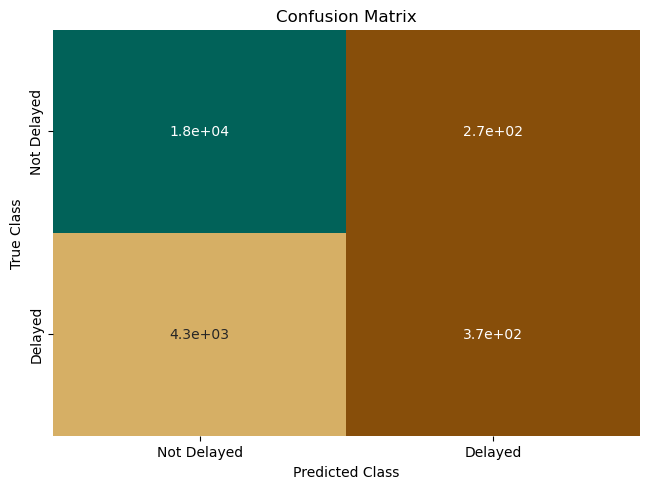

In [27]:
# Confusion Matrix
matrix = confusion_matrix(test_labels, target_predicted_binary)
df2_confusion = pd.DataFrame(matrix,  index=['Not Delayed','Delayed'],columns=['Not Delayed','Delayed'])

# Visualize Confusion Matrix
colormap = sns.color_palette("BrBG", 10)
sns.heatmap(df2_confusion, annot=True, cbar=None, cmap=colormap)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.ylabel("True Class")
plt.xlabel("Predicted Class")
plt.show()

Sensitivity or TPR: 7.84%
Specificity or TNR: 98.47%
Precision: 57.19%
Negative Predictive Value: 80.41%
False Positive Rate: 1.53%
False Negative Rate: 92.16%
False Discovery Rate: 42.81%
Accuracy: 79.75%


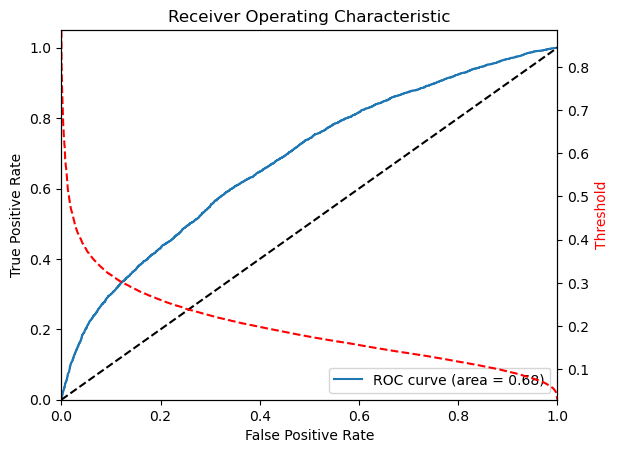

In [28]:
# Calculate confusion matrix
TN, FP, FN, TP = confusion_matrix(test_labels, target_predicted_binary).ravel()

# Calculate metrics
Sensitivity = TP / (TP + FN)
Specificity = TN / (TN + FP)
Precision = TP / (TP + FP)
NPV = TN / (TN + FN)
FPR = FP / (FP + TN)
FNR = FN / (TP + FN)
FDR = FP / (TP + FP)
ACC = (TP + TN) / (TP + FP + FN + TN)

# Print metrics
print(f"Sensitivity or TPR: {Sensitivity * 100:.2f}%")
print(f"Specificity or TNR: {Specificity * 100:.2f}%")
print(f"Precision: {Precision * 100:.2f}%")
print(f"Negative Predictive Value: {NPV * 100:.2f}%")
print(f"False Positive Rate: {FPR * 100:.2f}%")
print(f"False Negative Rate: {FNR * 100:.2f}%")
print(f"False Discovery Rate: {FDR * 100:.2f}%")
print(f"Accuracy: {ACC * 100:.2f}%")

# Calculate ROC AUC
roc_auc = roc_auc_score(test_labels, target_predicted['predicted'])

# Calculate ROC Curve
fpr, tpr, thresholds = roc_curve(test_labels, target_predicted['predicted'])

# Check if thresholds contain non-finite values
if not np.all(np.isfinite(thresholds)):
    # Exclude non-finite values from thresholds
    finite_indices = np.isfinite(thresholds)
    fpr = fpr[finite_indices]
    tpr = tpr[finite_indices]
    thresholds = thresholds[finite_indices]

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

# Create the axis of thresholds (scores)
ax2 = plt.gca().twinx()
ax2.plot(fpr, thresholds, markeredgecolor='r', linestyle='dashed', color='r')
ax2.set_ylabel('Threshold', color='r')
ax2.set_ylim([thresholds[-1], thresholds[0]])
ax2.set_xlim([fpr[0], fpr[-1]])

plt.show()

# Step 3: Build and evaluate ensembe models

Write code to perform the follwoing steps:
1. Split data into training, validation and testing sets (70% - 15% - 15%).
2. Use xgboost estimator to build a classifcation model.
3. Host the model on another instance
4. Perform batch transform to evaluate the model on testing data
5. Report the performance metrics that you see better test the model performance 
6. write down your observation on the difference between the performance of using the simple and ensemble models.
Note: You are required to perform the above steps on the two combined datasets separatey.

#  Combined_csv_v1.csv

In [1]:
# Import necessary libraries
import warnings
import pandas as pd
from sklearn.model_selection import train_test_split
import boto3
import sagemaker
from sagemaker.inputs import TrainingInput
from sagemaker.image_uris import retrieve
import os
import io
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [2]:
# Suppress warnings
warnings.simplefilter('ignore')

# Define your S3 bucket
bucket = 'c94466a2114434l5129986t1w904218779395-labbucket-162cf7bh3wrjs'

# Read in the CSV file
data_path = './data/combined_csv_v1.csv'
df3_csv1 = pd.read_csv(data_path)

In [3]:
# Split data into training, validation, and testing sets (70%, 15%, 15%)
train, test_and_validate = train_test_split(df3_csv1, test_size=0.3, random_state=42)
test, validate = train_test_split(test_and_validate, test_size=0.5, random_state=42)

In [4]:
# Define file names
prefix = 'lab3'
train_file = 'data_train.csv'
test_file = 'data_test.csv'
validate_file = 'data_validate.csv'

# Function to upload data to S3
s3_resource = boto3.Session().resource('s3')

def upload_s3_csv(filename, folder, dataframe):
    csv_buffer = io.StringIO()
    dataframe.to_csv(csv_buffer, header=False, index=False)
    s3_resource.Bucket(bucket).Object(os.path.join(prefix, folder, filename)).put(Body=csv_buffer.getvalue())

# Upload data to S3
upload_s3_csv(train_file, 'train', train)
upload_s3_csv(test_file, 'test', test)
upload_s3_csv(validate_file, 'validate', validate)

In [5]:
# Get XGBoost container
container = retrieve('xgboost', boto3.Session().region_name, '1.0-1')

# Define hyperparameters
hyperparams = {
    "num_round": "100",
    "eval_metric": "auc",
    "objective": "binary:logistic"
}

# Define output path
s3_output_location = "s3://{}/{}/output/".format(bucket, prefix)

# Define XGBoost model
xgb_model = sagemaker.estimator.Estimator(container,
                                          sagemaker.get_execution_role(),
                                          instance_count=1,
                                          instance_type='ml.m4.xlarge',
                                          output_path=s3_output_location,
                                          hyperparameters=hyperparams,
                                          sagemaker_session=sagemaker.Session())

# Define training and validation channels
train_channel = TrainingInput(
    "s3://{}/{}/train/".format(bucket, prefix, train_file),
    content_type='text/csv')

validate_channel = TrainingInput(
    "s3://{}/{}/validate/".format(bucket, prefix, validate_file),
    content_type='text/csv')

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [6]:
# Fit the model
data_channels = {'train': train_channel, 'validation': validate_channel}
xgb_model.fit(inputs=data_channels, logs=True)

# Batch transform
batch_X = test.iloc[:, 1:]

batch_X_file = 'batch-in.csv'
upload_s3_csv(batch_X_file, 'batch-in', batch_X)

batch_output = "s3://{}/{}/batch-out/".format(bucket, prefix)
batch_input = "s3://{}/{}/batch-in/{}".format(bucket, prefix, batch_X_file)

xgb_transformer = xgb_model.transformer(instance_count=1,
                                        instance_type='ml.m4.xlarge',
                                        strategy='MultiRecord',
                                        assemble_with='Line',
                                        output_path=batch_output)

xgb_transformer.transform(data=batch_input,
                          data_type='S3Prefix',
                          content_type='text/csv',
                          split_type='Line')
xgb_transformer.wait()

INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2023-11-02-16-44-21-442


2023-11-02 16:44:21 Starting - Starting the training job...
2023-11-02 16:44:46 Starting - Preparing the instances for training.........
2023-11-02 16:46:22 Downloading - Downloading input data...
2023-11-02 16:46:52 Training - Downloading the training image......
2023-11-02 16:47:38 Training - Training image download completed. Training in progress..[2023-11-02 16:47:54.726 ip-10-0-209-13.ec2.internal:7 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter eval_metric value auc to Json.
Returning the value itself
INFO:sagemaker-containers:Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:r

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2023-11-02-16-49-06-237
INFO:sagemaker:Creating transform job with name: sagemaker-xgboost-2023-11-02-16-49-06-939


.......................................
[2023-11-02:16:55:35:INFO] No GPUs detected (normal if no gpus installed)
[2023-11-02:16:55:35:INFO] No GPUs detected (normal if no gpus installed)
[2023-11-02:16:55:36:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;
  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }
  server {
    listen 8080 deferred;
    client_max_body_size 0;
    keepalive_timeout 3;
    location ~ ^/(ping|invocations|execution-parameters) {
      proxy_set_header X-Forwarded-For $proxy_add_x_forwarded_for;
      proxy_set_header Host $http_host;
      proxy_redirect off;
      proxy_read_timeout 60s;
      proxy_pass http://gunicorn;
    }
    location / {
      return 404 "{}";
    }
  }
}
[2023-11-02 16:55:36 +0000] [20] [INFO] Star

In [7]:
# Get the results
s3_client = boto3.client('s3')
obj = s3_client.get_object(Bucket=bucket, Key="{}/batch-out/{}".format(prefix, 'batch-in.csv.out'))
target_predicted = pd.read_csv(io.BytesIO(obj['Body'].read()), names=['predicted'])

In [8]:
# Convert probabilities to binary
def binary_convert(x, threshold=0.5):
    return int(x > threshold)

target_predicted_binary = target_predicted['predicted'].apply(binary_convert)

# Get the true labels
test_labels = test.iloc[:, 0]

# Calculate performance metrics
from sklearn.metrics import classification_report

print(classification_report(test_labels, target_predicted_binary))

              precision    recall  f1-score   support

         0.0       0.82      0.98      0.90     16743
         1.0       0.71      0.18      0.29      4295

    accuracy                           0.82     21038
   macro avg       0.77      0.58      0.59     21038
weighted avg       0.80      0.82      0.77     21038



In [9]:
test_labels = test.iloc[:,0]
test_labels.head()

74393     1.0
132169    0.0
36467     0.0
101964    0.0
48199     1.0
Name: target, dtype: float64

In [10]:
matrix = confusion_matrix(test_labels, target_predicted_binary)
df3_confusion = pd.DataFrame(matrix, index=['Not Delayed','Delayed'],columns=['Not Delayed','Delayed'])

df3_confusion

,Not Delayed,Delayed
Not Delayed,16418,325
Delayed,3510,785


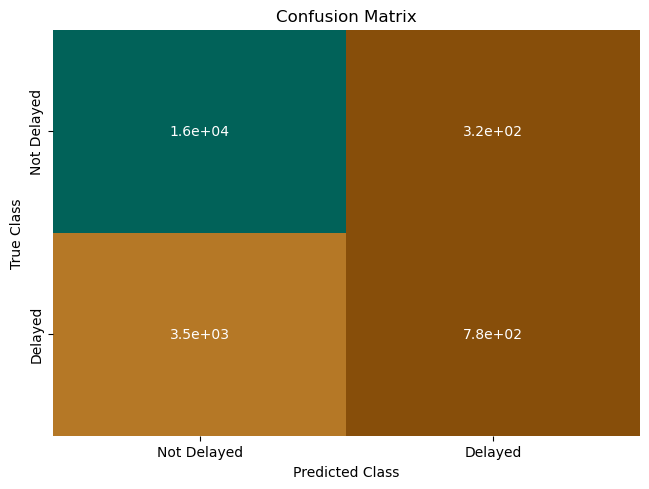

In [11]:
colormap = sns.color_palette("BrBG", 10)
sns.heatmap(df3_confusion, annot=True, cbar=None, cmap=colormap)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.ylabel("True Class")
plt.xlabel("Predicted Class")
plt.show()

Sensitivity or TPR: 18.28%
Specificity or TNR: 98.06%
Precision: 70.72%
Negative Predictive Value: 82.39%
False Positive Rate: 1.94%
False Negative Rate: 81.72%
False Discovery Rate: 29.28%
Accuracy: 81.77%


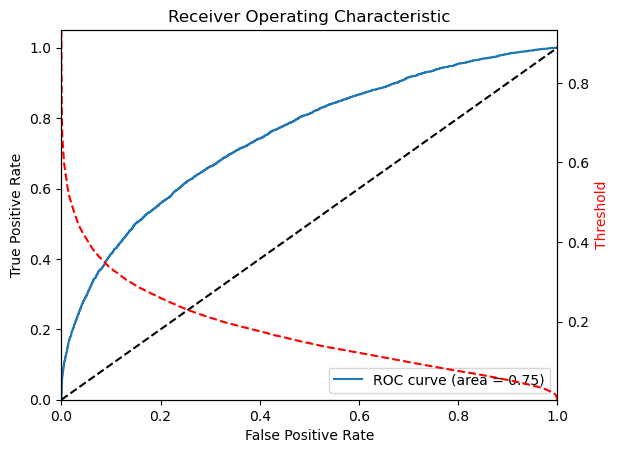

In [12]:
# Calculate confusion matrix
TN, FP, FN, TP = confusion_matrix(test_labels, target_predicted_binary).ravel()

# Calculate metrics
Sensitivity = TP / (TP + FN)
Specificity = TN / (TN + FP)
Precision = TP / (TP + FP)
NPV = TN / (TN + FN)
FPR = FP / (FP + TN)
FNR = FN / (TP + FN)
FDR = FP / (TP + FP)
ACC = (TP + TN) / (TP + FP + FN + TN)

# Print metrics
print(f"Sensitivity or TPR: {Sensitivity * 100:.2f}%")
print(f"Specificity or TNR: {Specificity * 100:.2f}%")
print(f"Precision: {Precision * 100:.2f}%")
print(f"Negative Predictive Value: {NPV * 100:.2f}%")
print(f"False Positive Rate: {FPR * 100:.2f}%")
print(f"False Negative Rate: {FNR * 100:.2f}%")
print(f"False Discovery Rate: {FDR * 100:.2f}%")
print(f"Accuracy: {ACC * 100:.2f}%")

# Calculate ROC AUC
roc_auc = roc_auc_score(test_labels, target_predicted['predicted'])

# Calculate ROC Curve
fpr, tpr, thresholds = roc_curve(test_labels, target_predicted['predicted'])

# Check if thresholds contain non-finite values
if not np.all(np.isfinite(thresholds)):
    # Exclude non-finite values from thresholds
    finite_indices = np.isfinite(thresholds)
    fpr = fpr[finite_indices]
    tpr = tpr[finite_indices]
    thresholds = thresholds[finite_indices]

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

# Create the axis of thresholds (scores)
ax2 = plt.gca().twinx()
ax2.plot(fpr, thresholds, markeredgecolor='r', linestyle='dashed', color='r')
ax2.set_ylabel('Threshold', color='r')
ax2.set_ylim([thresholds[-1], thresholds[0]])
ax2.set_xlim([fpr[0], fpr[-1]])

plt.show()

# Combined_csv_v2.csv

In [13]:
# Import necessary libraries
import warnings
import pandas as pd
from sklearn.model_selection import train_test_split
import boto3
import sagemaker
from sagemaker.inputs import TrainingInput
from sagemaker.image_uris import retrieve
import os
import io
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc


In [14]:
# Suppress warnings
warnings.simplefilter('ignore')

# Define your S3 bucket
bucket = 'c94466a2114434l5129986t1w904218779395-labbucket-162cf7bh3wrjs'

# Read in the CSV file
data_path = './data/combined_csv_v2.csv'
df4_csv1 = pd.read_csv(data_path)

In [15]:
# Split data into training, validation, and testing sets (70%, 15%, 15%)
train, test_and_validate = train_test_split(df4_csv1, test_size=0.3, random_state=42)
test, validate = train_test_split(test_and_validate, test_size=0.5, random_state=42)

In [16]:
# Define file names
prefix = 'lab4'
train_file = 'data_train.csv'
test_file = 'data_test.csv'
validate_file = 'data_validate.csv'

# Function to upload data to S3
s3_resource = boto3.Session().resource('s3')

def upload_s3_csv(filename, folder, dataframe):
    csv_buffer = io.StringIO()
    dataframe.to_csv(csv_buffer, header=False, index=False)
    s3_resource.Bucket(bucket).Object(os.path.join(prefix, folder, filename)).put(Body=csv_buffer.getvalue())

# Upload data to S3
upload_s3_csv(train_file, 'train', train)
upload_s3_csv(test_file, 'test', test)
upload_s3_csv(validate_file, 'validate', validate)

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


In [17]:
# Get XGBoost container
container = retrieve('xgboost', boto3.Session().region_name, '1.0-1')

# Define hyperparameters
hyperparams = {
    "num_round": "100",
    "eval_metric": "auc",
    "objective": "binary:logistic"
}

# Define output path
s3_output_location = "s3://{}/{}/output/".format(bucket, prefix)

# Define XGBoost model
xgb_model = sagemaker.estimator.Estimator(container,
                                          sagemaker.get_execution_role(),
                                          instance_count=1,
                                          instance_type='ml.m4.xlarge',
                                          output_path=s3_output_location,
                                          hyperparameters=hyperparams,
                                          sagemaker_session=sagemaker.Session())

# Define training and validation channels
train_channel = TrainingInput(
    "s3://{}/{}/train/".format(bucket, prefix, train_file),
    content_type='text/csv')

validate_channel = TrainingInput(
    "s3://{}/{}/validate/".format(bucket, prefix, validate_file),
    content_type='text/csv')

INFO:sagemaker.image_uris:Defaulting to only available Python version: py3
INFO:sagemaker.image_uris:Defaulting to only supported image scope: cpu.


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [18]:
# Fit the model
data_channels = {'train': train_channel, 'validation': validate_channel}
xgb_model.fit(inputs=data_channels, logs=True)

# Batch transform
batch_X = test.iloc[:, 1:]

batch_X_file = 'batch-in.csv'
upload_s3_csv(batch_X_file, 'batch-in', batch_X)

batch_output = "s3://{}/{}/batch-out/".format(bucket, prefix)
batch_input = "s3://{}/{}/batch-in/{}".format(bucket, prefix, batch_X_file)

xgb_transformer = xgb_model.transformer(instance_count=1,
                                        instance_type='ml.m4.xlarge',
                                        strategy='MultiRecord',
                                        assemble_with='Line',
                                        output_path=batch_output)

xgb_transformer.transform(data=batch_input,
                          data_type='S3Prefix',
                          content_type='text/csv',
                          split_type='Line')
xgb_transformer.wait()

INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2023-11-02-17-03-55-725


2023-11-02 17:03:55 Starting - Starting the training job...
2023-11-02 17:04:11 Starting - Preparing the instances for training.........
2023-11-02 17:05:35 Downloading - Downloading input data...
2023-11-02 17:06:15 Training - Downloading the training image...
2023-11-02 17:06:56 Training - Training image download completed. Training in progress....[2023-11-02 17:07:06.965 ip-10-2-85-125.ec2.internal:7 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter eval_metric value auc to Json.
Returning the value itself
INFO:sagemaker-containers:Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:ro

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2023-11-02-17-09-13-973
INFO:sagemaker:Creating transform job with name: sagemaker-xgboost-2023-11-02-17-09-14-712


..........................................[2023-11-02:17:16:20:INFO] No GPUs detected (normal if no gpus installed)
[2023-11-02:17:16:20:INFO] No GPUs detected (normal if no gpus installed)
[2023-11-02:17:16:20:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;
  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }
  server {
    listen 8080 deferred;
    client_max_body_size 0;
    keepalive_timeout 3;
    location ~ ^/(ping|invocations|execution-parameters) {
      proxy_set_header X-Forwarded-For $proxy_add_x_forwarded_for;
      proxy_set_header Host $http_host;
      proxy_redirect off;
      proxy_read_timeout 60s;
      proxy_pass http://gunicorn;
    }
    location / {
      return 404 "{}";
    }
  }
}
[2023-11-02 17:16:20 +0000] [19] [INFO] St

In [19]:
# Get the results
s3_client = boto3.client('s3')
obj = s3_client.get_object(Bucket=bucket, Key="{}/batch-out/{}".format(prefix, 'batch-in.csv.out'))
target_predicted = pd.read_csv(io.BytesIO(obj['Body'].read()), names=['predicted'])

In [20]:
# Convert probabilities to binary
def binary_convert(x, threshold=0.5):
    return int(x > threshold)

target_predicted_binary = target_predicted['predicted'].apply(binary_convert)

# Get the true labels
test_labels = test.iloc[:, 0]

# Calculate performance metrics
from sklearn.metrics import classification_report

print(classification_report(test_labels, target_predicted_binary))

              precision    recall  f1-score   support

         0.0       0.81      0.97      0.89     67063
         1.0       0.70      0.22      0.34     19104

    accuracy                           0.81     86167
   macro avg       0.76      0.60      0.61     86167
weighted avg       0.79      0.81      0.76     86167



In [21]:
matrix = confusion_matrix(test_labels, target_predicted_binary)
df4_confusion = pd.DataFrame(matrix, index=['Not Delayed','Delayed'],columns=['Not Delayed','Delayed'])

df4_confusion

,Not Delayed,Delayed
Not Delayed,65269,1794
Delayed,14884,4220


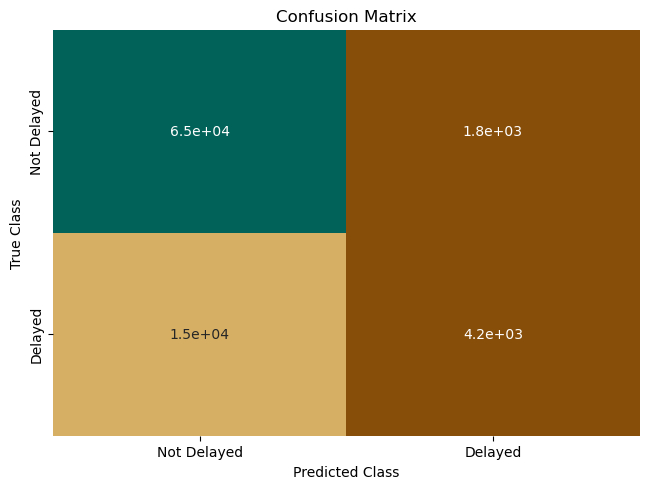

In [22]:
colormap = sns.color_palette("BrBG", 10)
sns.heatmap(df4_confusion, annot=True, cbar=None, cmap=colormap)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.ylabel("True Class")
plt.xlabel("Predicted Class")
plt.show()

Sensitivity or TPR: 22.09%
Specificity or TNR: 97.32%
Precision: 70.17%
Negative Predictive Value: 81.43%
False Positive Rate: 2.68%
False Negative Rate: 77.91%
False Discovery Rate: 29.83%
Accuracy: 80.64%


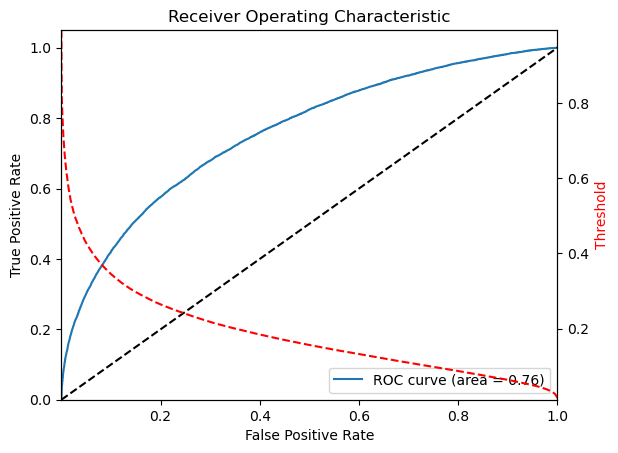

In [23]:
# Calculate confusion matrix
TN, FP, FN, TP = confusion_matrix(test_labels, target_predicted_binary).ravel()

# Calculate metrics
Sensitivity = TP / (TP + FN)
Specificity = TN / (TN + FP)
Precision = TP / (TP + FP)
NPV = TN / (TN + FN)
FPR = FP / (FP + TN)
FNR = FN / (TP + FN)
FDR = FP / (TP + FP)
ACC = (TP + TN) / (TP + FP + FN + TN)

# Print metrics
print(f"Sensitivity or TPR: {Sensitivity * 100:.2f}%")
print(f"Specificity or TNR: {Specificity * 100:.2f}%")
print(f"Precision: {Precision * 100:.2f}%")
print(f"Negative Predictive Value: {NPV * 100:.2f}%")
print(f"False Positive Rate: {FPR * 100:.2f}%")
print(f"False Negative Rate: {FNR * 100:.2f}%")
print(f"False Discovery Rate: {FDR * 100:.2f}%")
print(f"Accuracy: {ACC * 100:.2f}%")

# Calculate ROC AUC
roc_auc = roc_auc_score(test_labels, target_predicted['predicted'])

# Calculate ROC Curve
fpr, tpr, thresholds = roc_curve(test_labels, target_predicted['predicted'])

# Check if thresholds contain non-finite values
if not np.all(np.isfinite(thresholds)):
    # Exclude non-finite values from thresholds
    finite_indices = np.isfinite(thresholds)
    fpr = fpr[finite_indices]
    tpr = tpr[finite_indices]
    thresholds = thresholds[finite_indices]

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

# Create the axis of thresholds (scores)
ax2 = plt.gca().twinx()
ax2.plot(fpr, thresholds, markeredgecolor='r', linestyle='dashed', color='r')
ax2.set_ylabel('Threshold', color='r')
ax2.set_ylim([thresholds[-1], thresholds[0]])
ax2.set_xlim([fpr[0], fpr[-1]])

plt.show()

### Conclusion CSV1

Let's review the CSV1 metrics for each:

linear estimator model:
Confusion Matrix:

True Negative (Not Delayed, Predicted Not Delayed): 1.7e+03
False Positive (Not Delayed, Predicted Delayed): 1.1e+02
False Negative (Delayed, Predicted Not Delayed): 4.1e+02
True Positive (Delayed, Predicted Delayed): 1.9e+02

Performance Metrics:

Sensitivity or True Positive Rate (TPR): 31.43%
Specificity or True Negative Rate (TNR): 93.99%
Precision: 63.82%
Negative Predictive Value: 80.24%
False Positive Rate: 6.01%
False Negative Rate: 68.57%
False Discovery Rate: 36.18%

Accuracy: 78.20%
ROC Curve Area: 0.77


xgboost estimator:
Confusion Matrix:

True Negative (Not Delayed, Predicted Not Delayed): 1.6e+04
False Positive (Not Delayed, Predicted Delayed): 3.2e+02
False Negative (Delayed, Predicted Not Delayed): 3.5e+03
True Positive (Delayed, Predicted Delayed): 7.8e+02

Performance Metrics:

Sensitivity or True Positive Rate (TPR): 18.28%
Specificity or True Negative Rate (TNR): 98.06%
Precision: 70.72%
Negative Predictive Value: 82.39%
False Positive Rate: 1.94%
False Negative Rate: 81.72%
False Discovery Rate: 29.28%

Accuracy: 81.77%
ROC Curve Area: 0.75

The Accuracy is slightly higher in the second dataset (81.77% compared to 78.20%), which indicates the second model performs marginally better in overall classification.

However, the Sensitivity or True Positive Rate is higher in the linear estimator model (31.43% vs. 18.28%). This means the first model is better at correctly identifying positive cases (or detecting the 'Delayed' class) compared to the second model.

The Specificity or True Negative Rate is higher in the xgboost estimator (98.06% vs. 93.99%), indicating the second model is better at correctly identifying negative cases.

The Precision of the second model is also higher (70.72% vs. 63.82%), which means that among all the positive predictions made by the second model, a higher percentage of them were actually correct.

The ROC Curve Area is slightly higher for the first model, suggesting that the model for the first model might be slightly more reliable in distinguishing between the two classes.

Conclusion:

While the second model has a marginally higher accuracy and better specificity, the first model has a superior sensitivity. This means if the priority is to detect more positive cases (like identifying 'Delayed' flights), the first model might be preferred, but if the priority is to correctly identify negative cases and have a higher overall accuracy, the second model would be preferable.


### Conclusion CSV2

Let's start by analyzing the performance metrics of both modules:

linear estimator model:
Precision, Recall, and F1-score:
Not Delayed: Precision: 0.80, Recall: 0.98, F1-score: 0.89
Delayed: Precision: 0.57, Recall: 0.08, F1-score: 0.14

Accuracy: 0.69
Macro avg F1-score: 0.51
Weighted avg F1-score: 0.73

Confusion Matrix:
Not Delayed (True Positive): ~1.8e+04
Delayed (False Negative): ~2.7e+02
Not Delayed (False Positive): ~4.3e+03
Delayed (True Negative): ~3.7e+02

Receiver Operating Characteristic (ROC):
Area under the curve (AUC): 0.68

xgboost estimator:
Precision, Recall, and F1-score:
Not Delayed: Precision: 0.81, Recall: 0.97, F1-score: 0.89
Delayed: Precision: 0.70, Recall: 0.22, F1-score: 0.34

Accuracy: 0.76
Macro avg F1-score: 0.60
Weighted avg F1-score: 0.76

Confusion Matrix:
Not Delayed (True Positive): ~6.5e+04
Delayed (False Negative): ~1.8e+03
Not Delayed (False Positive): ~1.5e+04
Delayed (True Negative): ~4.2e+03

Receiver Operating Characteristic (ROC):
Area under the curve (AUC): 0.76

Precision and Recall: The xgboost estimator seems to perform better in terms of precision and recall for the 'Delayed' class. This is evident by the improved precision (0.70 vs 0.57) and recall (0.22 vs 0.08) for the 'Delayed' class in the xgboost estimator.

Accuracy: The xgboost estimator has a slightly higher accuracy (0.76 vs 0.69).

F1-score: The xgboost estimator has a better macro average F1-score, indicating a more balanced performance between the two classes.

ROC-AUC: The area under the curve for the xgboost estimator is higher (0.76 vs 0.68), indicating better overall performance in distinguishing between the two classes.

Confusion Matrix: The xgboost estimator has a greater number of true positives and true negatives, which means it's doing a better job at correctly classifying both classes. However, the number of false negatives is also higher in the xgboost estimator, which can be concerning depending on the application.

In conclusion, the xgboost estimator seems to have a better performance overall in terms of precision, recall, F1-score, accuracy, and ROC-AUC. However, the specific choice of the best model can also depend on the application and the relative importance of false positives and false negatives. For instance, in critical applications, a high false negative rate might be unacceptable, even if other metrics are good.

